In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import sys

sys.path.append('../')
import src.read_raw as rr

In [347]:
with open('../playground/cfcme.dat','r') as f:
    files = [x.strip() for x in f]
df = rr.combine_files(files,io='I')
df = rr.realign(df)

In [348]:
print df.orbit.unique()

[817 818 819 820 821 823 824 825 826 827 828 829 830]


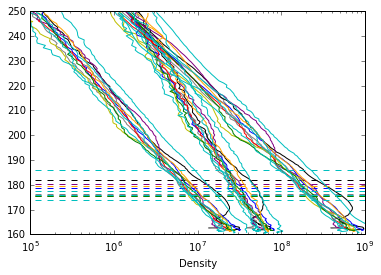

In [353]:
plt.figure()
cs = ['gray','gray','k','purple','b','r','orange','y','g','c','c','c','c','c','c']
exo_alts, exo_sg = [],[]
bindf = []
t_Ar = []
for i,[orb,orbdata] in enumerate(df[(df['alt']<250)&(df['orbit']<831)].groupby('orbit')):
    plt.plot(orbdata['abundance_Ar'],orbdata['alt'],c=cs[i])
    plt.plot(orbdata['abundance_N2'],orbdata['alt'],c=cs[i])
    plt.plot(orbdata['abundance_CO2'],orbdata['alt'],c=cs[i])
    
    #plt.plot(orbdata['abundance_O'],orbdata['alt'],c=cs[i])
    exo = exo_Ar_int(orbdata['abundance_CO2'],orbdata['alt'])[0]
    exo_alts.append(exo)
    sg_CO2 = rr.savgol_density(orbdata['abundance_CO2'])
    sg_Ar = rr.savgol_density(orbdata['abundance_Ar'])
    exo_sg.append(exo_Ar_int(sg_CO2,orbdata['alt']))
    t_Ar.append(x_to_T(sps.linregress(orbdata['alt'],np.log(sg_Ar))[0],40))
    plt.plot([1.e+4,1.e+9],[exo,exo],c=cs[i],ls='--')
    if orb < 823:
        bindf.append(orbdata)
        
plt.xscale('log')
plt.xlim(1.e+5,1.e+9)
plt.xlabel('Density')
plt.show()

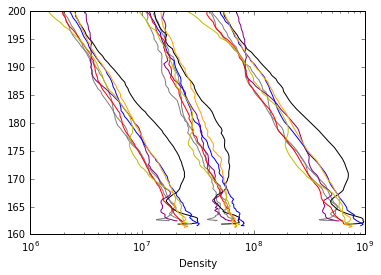

In [145]:
plt.figure()
for i,[orb,orbdata] in enumerate(df.groupby('orbit')):
    plt.plot(orbdata['abundance_Ar'],orbdata['alt'],c=cs[i])
    plt.plot(orbdata['abundance_N2'],orbdata['alt'],c=cs[i])
    plt.plot(orbdata['abundance_CO2'],orbdata['alt'],c=cs[i])
plt.xscale('log')
plt.xlabel('Density')
plt.xlim(1.e+6,1.e+9)
plt.ylim(160,200)
plt.show()

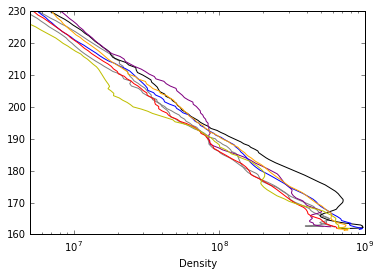

In [146]:
plt.figure()
for i,[orb,orbdata] in enumerate(df.groupby('orbit')):
    plt.plot(orbdata['abundance_CO2'],orbdata['alt'],c=cs[i])
plt.xscale('log')
plt.xlabel('Density')
plt.xlim(5.e+6,1.e+9)
plt.ylim(160,230)
plt.show()

In [283]:
import scipy.integrate as spi
import scipy.stats as sps
def exo_Ar_int(CO2,alt,exsp=['CO2'],ArXsec=[3.e-15],\
           Ntop=[0.,0.],taufrange=[0.5,1.5]):
    '''
    Calculate exobase altitude from species profiles
    (BE SURE TO USE INBOUND)
    Integrates down from some initial altitude to periapse
    Determines where num_density*coll_x-sec = 1 for exo altitude

    Inputs
    ------
    exsp: list, species to use in calculation
    ArXsec: list, collisional cross section for each species in exsp
    Ntop: list, column density above top for each species

    Outputs
    -------
    exo: float, exobase altitude
    fitTau: fit parameters of Tau profile (see scipy.stats.linregress)


    **TO DO:
    cite cross section values, should extrapolate ones that don't reac tau=1
    '''
    #convert alts to cm
    #orb_df = orb_df[orb_df['abundance_CO2']>0]
    xsec = dict(zip(exsp,ArXsec))
    altkm = np.array(alt)*1.e+5
    Tau_sp_dz = np.zeros((len(exsp),len(altkm)))  #initialize Tau/z
    for i,s in enumerate(xsec): #loop through species to use
        #colname = 'abundance_'+s
        #if colname in orb_df.columns: #check given species in DF
        Tau_sp_dz[i] = CO2*xsec[s] #calc n*sigma
        #else:
        #    print 'has no column '+colname
        #    return np.NaN
    Tau_tot_dz = np.sum(Tau_sp_dz,axis=0) #add each sp n*sigma together
    Tau_int = spi.cumtrapz(Tau_tot_dz,altkm*-1) #n*dz*sigma=N*sigma=Tau
    altmids = ((altkm[1:] + altkm[:-1]) / 2)/1.e+5 #gid mid alts in km
    findTau1 = np.where((Tau_int>taufrange[0])&(Tau_int<taufrange[-1])) #cond to find Tau=1
    if len(Tau_int[findTau1])<5: #warn if fitting line to only a few pts
        if np.max(Tau_int) < 1.0:
            print 'Never reaches tau=1, <'+str(int(altmids[-1]))+'?'
            return np.NaN, (np.NaN,np.NaN,np.NaN,np.NaN,np.NaN)
        else:
            print 'Has <5 points near tau=1'
            return np.NaN, (np.NaN,np.NaN,np.NaN,np.NaN,np.NaN)
    fitTau = sps.linregress(altmids[findTau1],Tau_int[findTau1])
    exo = (1-fitTau[1])/fitTau[0] #find alt where Tau=1
    return exo,fitTau #return exobase altitude
    

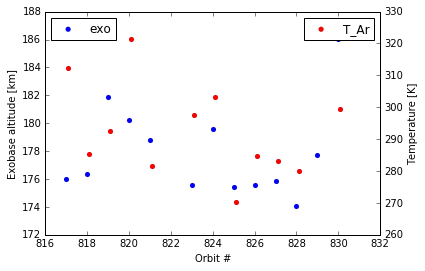

In [354]:
fig,ax = plt.subplots()
ax.scatter(df.orbit.unique(),exo_alts,lw=0.1,s=25,label='exo')
ax.set_ylabel('Exobase altitude [km]')
ax1 = plt.twinx()
ax1.scatter(df.orbit.unique()+0.1,t_Ar,c='r',lw=0.1,s=25,label='T_Ar')
ax1.set_ylabel('Temperature [K]')
ax.set_xlabel('Orbit #')
ax.legend(loc=2,scatterpoints=1)
ax1.legend(scatterpoints=1)
plt.show()

In [208]:
p4 = pd.concat(bindf)

In [355]:
bins = np.arange(140,300,5)
p4['bin'] = pd.cut(p4['alt'],bins)

p4bin = p4[['alt','abundance_CO2','abundance_Ar','abundance_N2']].groupby(p4['bin']).mean().reset_index()
p4bin.dropna(inplace=True)
p4bin.head()

p4bin_sd = p4[['alt','abundance_CO2','abundance_Ar','abundance_N2']].groupby(p4['bin']).std().reset_index()
p4bin_sd.dropna(inplace=True)
p4bin_sd.head()

,bin,alt,abundance_CO2,abundance_Ar,abundance_N2
4,"(160, 165]",0.860602,1.615624e+08,5.150135e+06,1.119016e+07
5,"(165, 170]",1.437422,8.139007e+07,2.597767e+06,6.309828e+06
6,"(170, 175]",1.457454,1.428208e+08,4.602023e+06,8.707658e+06
7,"(175, 180]",1.454085,9.938172e+07,3.607324e+06,9.244601e+06
8,"(180, 185]",1.474871,4.982322e+07,2.039337e+06,7.174947e+06


In [361]:
df1 = df[(df['orbit']==823)&(df['alt']<250)]
df2 = df[(df['orbit']==824)&(df['alt']<250)]
df3 = df[(df['orbit']==825)&(df['alt']<250)]
df4 = df[(df['orbit']==826)&(df['alt']<250)]
df5 = df[(df['orbit']==827)&(df['alt']<250)]

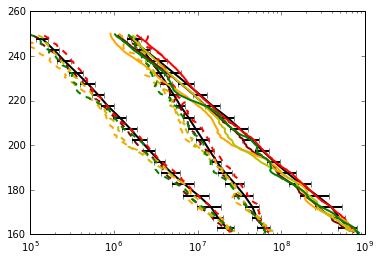

In [362]:
plt.figure()
plt.errorbar(p4bin['abundance_Ar'],p4bin['alt'],xerr=p4bin_sd['abundance_Ar'],c='k',lw=2,label='Ar')
plt.errorbar(p4bin['abundance_N2'],p4bin['alt'],xerr=p4bin_sd['abundance_N2'],c='k',lw=2,label='N2')
plt.errorbar(p4bin['abundance_CO2'],p4bin['alt'],xerr=p4bin_sd['abundance_CO2'],c='k',lw=2,label='CO2')

plt.plot(df1['abundance_Ar'],df1['alt'],color='darkred',lw=2,ls='--',label='Ar')
plt.plot(df1['abundance_N2'],df1['alt'],color='darkred',lw=2,ls='--',label='N2')
plt.plot(df1['abundance_CO2'],df1['alt'],color='darkred',lw=2,ls='-',label='CO2')

plt.plot(df2['abundance_Ar'],df2['alt'],color='r',lw=2,ls='--',label='Ar')
plt.plot(df2['abundance_N2'],df2['alt'],color='r',lw=2,ls='--',label='N2')
plt.plot(df2['abundance_CO2'],df2['alt'],color='r',lw=2,ls='-',label='CO2')

plt.plot(df3['abundance_Ar'],df3['alt'],color='orange',lw=2,ls='--',label='Ar')
plt.plot(df3['abundance_N2'],df3['alt'],color='orange',lw=2,ls='--',label='N2')
plt.plot(df3['abundance_CO2'],df3['alt'],color='orange',lw=2,ls='-',label='CO2')


plt.plot(df4['abundance_Ar'],df4['alt'],color='y',lw=2,ls='--',label='Ar')
plt.plot(df4['abundance_N2'],df4['alt'],color='y',lw=2,ls='--',label='N2')
plt.plot(df4['abundance_CO2'],df4['alt'],color='y',lw=2,ls='-',label='CO2')

plt.plot(df5['abundance_Ar'],df5['alt'],color='g',lw=2,ls='--',label='Ar')
plt.plot(df5['abundance_N2'],df5['alt'],color='g',lw=2,ls='--',label='N2')
plt.plot(df5['abundance_CO2'],df5['alt'],color='g',lw=2,ls='-',label='CO2')

plt.xscale('log')
plt.ylim(160,260)
plt.xlim(1.e+5,1.e+9)
plt.show()

In [285]:
p4exo = p4bin[p4bin['alt']<240].sort_values('alt',ascending=False)
#p4exo
exo_Ar_int(p4exo['abundance_CO2'],p4exo['alt'])

Has <5 points near tau=1


(nan, (nan, nan, nan, nan, nan))

In [331]:
p4 = p4.sort_values('alt',ascending=False)
p4['sg_Ar'] = rr.savgol_density(p4['abundance_Ar'],winsize=501,poly=2)
p4['sg_N2'] = rr.savgol_density(p4['abundance_N2'],winsize=501,poly=2)
p4['sg_CO2'] = rr.savgol_density(p4['abundance_CO2'],winsize=501,poly=2)

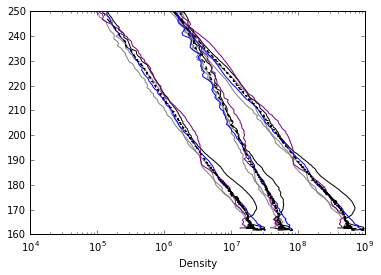

In [231]:
plt.figure()
for i,[orb,orbdata] in enumerate(p4[p4['alt']<250].groupby('orbit')):
    plt.plot(orbdata['abundance_Ar'],orbdata['alt'],c=cs[i])
    plt.plot(orbdata['abundance_N2'],orbdata['alt'],c=cs[i])
    plt.plot(orbdata['abundance_CO2'],orbdata['alt'],c=cs[i])
plt.plot(p4['sg_Ar'],p4['alt'],'k--')
plt.plot(p4['sg_N2'],p4['alt'],'k--')
plt.plot(p4['sg_CO2'],p4['alt'],'k--')
plt.xscale('log')
plt.xlabel('Density')
plt.show()

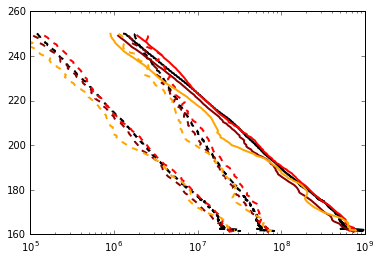

In [315]:
plt.figure()
#plt.plot(p4bin['abundance_Ar'],p4bin['alt'],'k--',lw=2,label='Ar')
#plt.plot(p4bin['abundance_N2'],p4bin['alt'],'k--',lw=2,label='N2')
#plt.plot(p4bin['abundance_CO2'],p4bin['alt'],'k',lw=2,label='CO2')

plt.plot(p4['sg_Ar'],p4['alt'],'k--',lw=2,label='Ar')
plt.plot(p4['sg_N2'],p4['alt'],'k--',lw=2,label='N2')
plt.plot(p4['sg_CO2'],p4['alt'],'k',lw=2,label='CO2')

plt.plot(df1['abundance_Ar'],df1['alt'],color='darkred',lw=2,ls='--',label='Ar')
plt.plot(df1['abundance_N2'],df1['alt'],color='darkred',lw=2,ls='--',label='N2')
plt.plot(df1['abundance_CO2'],df1['alt'],color='darkred',lw=2,ls='-',label='CO2')

plt.plot(df2['abundance_Ar'],df2['alt'],color='r',lw=2,ls='--',label='Ar')
plt.plot(df2['abundance_N2'],df2['alt'],color='r',lw=2,ls='--',label='N2')
plt.plot(df2['abundance_CO2'],df2['alt'],color='r',lw=2,ls='-',label='CO2')

plt.plot(df3['abundance_Ar'],df3['alt'],color='orange',lw=2,ls='--',label='Ar')
plt.plot(df3['abundance_N2'],df3['alt'],color='orange',lw=2,ls='--',label='N2')
plt.plot(df3['abundance_CO2'],df3['alt'],color='orange',lw=2,ls='-',label='CO2')

plt.xscale('log')
plt.ylim(160,260)
plt.xlim(1.e+5,1.e+9)
plt.show()

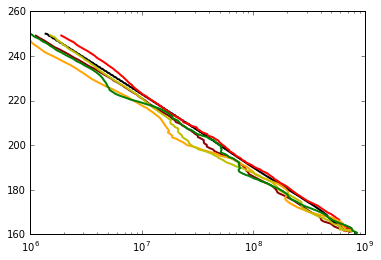

In [363]:
plt.figure()

plt.plot(p4['sg_CO2'],p4['alt'],'k',lw=2,label='CO2')

plt.plot(df1['abundance_CO2'],df1['alt'],color='darkred',lw=2,ls='-',label='CO2')

plt.plot(df2['abundance_CO2'],df2['alt'],color='r',lw=2,ls='-',label='CO2')

plt.plot(df3['abundance_CO2'],df3['alt'],color='orange',lw=2,ls='-',label='CO2')

plt.plot(df4['abundance_CO2'],df4['alt'],color='y',lw=2,ls='-',label='CO2')

plt.plot(df5['abundance_CO2'],df5['alt'],color='g',lw=2,ls='-',label='CO2')

plt.xscale('log')
plt.ylim(160,260)
plt.xlim(1.e+6,1.e+9)
plt.show()

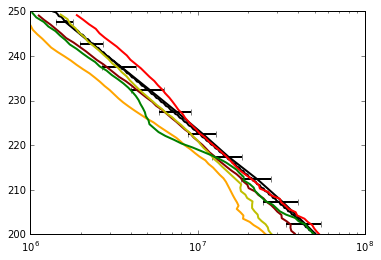

In [373]:
plt.figure()

plt.plot(p4['sg_CO2'],p4['alt'],'k',lw=2,label='CO2')
plt.errorbar(p4bin['abundance_CO2'],p4bin['alt'],xerr=p4bin_sd['abundance_CO2'],c='k',lw=2,label='CO2')

plt.plot(df1['abundance_CO2'],df1['alt'],color='darkred',lw=2,ls='-',label='CO2')

plt.plot(df2['abundance_CO2'],df2['alt'],color='r',lw=2,ls='-',label='CO2')

plt.plot(df3['abundance_CO2'],df3['alt'],color='orange',lw=2,ls='-',label='CO2')

plt.plot(df4['abundance_CO2'],df4['alt'],color='y',lw=2,ls='-',label='CO2')

plt.plot(df5['abundance_CO2'],df5['alt'],color='g',lw=2,ls='-',label='CO2')

plt.xscale('log')
plt.ylim(200,250)
plt.xlim(1.e+6,1.e+8)
plt.show()

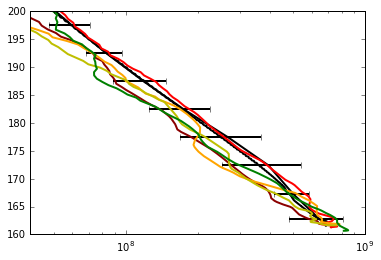

In [372]:
plt.figure()

plt.plot(p4['sg_CO2'],p4['alt'],'k',lw=2,label='CO2')
plt.errorbar(p4bin['abundance_CO2'],p4bin['alt'],xerr=p4bin_sd['abundance_CO2'],c='k',lw=2,label='CO2')

plt.plot(df1['abundance_CO2'],df1['alt'],color='darkred',lw=2,ls='-',label='CO2')

plt.plot(df2['abundance_CO2'],df2['alt'],color='r',lw=2,ls='-',label='CO2')

plt.plot(df3['abundance_CO2'],df3['alt'],color='orange',lw=2,ls='-',label='CO2')

plt.plot(df4['abundance_CO2'],df4['alt'],color='y',lw=2,ls='-',label='CO2')

plt.plot(df5['abundance_CO2'],df5['alt'],color='g',lw=2,ls='-',label='CO2')

plt.xscale('log')
plt.ylim(160,200)
plt.xlim(4.e+7,1.e+9)
plt.show()

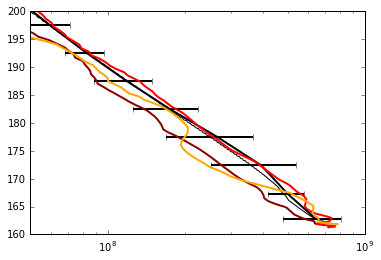

In [371]:
plt.figure()

plt.plot(p4['sg_CO2'],p4['alt'],'k',lw=1,label='CO2')


plt.plot(df1['abundance_CO2'],df1['alt'],color='darkred',lw=2,ls='-',label='CO2')

plt.plot(df2['abundance_CO2'],df2['alt'],color='r',lw=2,ls='-',label='CO2')

plt.plot(df3['abundance_CO2'],df3['alt'],color='orange',lw=2,ls='-',label='CO2')

plt.xscale('log')
plt.ylim(160,200)
plt.xlim(5.e+7,1.e+9)
plt.show()

In [286]:
p4exo = p4[p4['alt']<240].sort_values('alt',ascending=False)
#p4exo
exo_Ar_int(p4exo['sg_CO2'],p4exo['alt'])[0]

178.43019165390677

In [271]:
ta = sps.linregress(p4exo['alt'],np.log(p4exo['sg_Ar']))
tn = sps.linregress(p4exo['alt'],np.log(p4exo['sg_N2']))
tc = sps.linregress(p4exo['alt'],np.log(p4exo['sg_CO2']))

ta1 = sps.linregress(df1['alt'],np.log(df1['abundance_Ar']))
tn1 = sps.linregress(df1['alt'],np.log(df1['abundance_N2']))
tc1 = sps.linregress(df1['alt'],np.log(df1['abundance_CO2']))


ta2 = sps.linregress(df2['alt'],np.log(df2['abundance_Ar']))
tn2 = sps.linregress(df2['alt'],np.log(df2['abundance_N2']))
tc2 = sps.linregress(df2['alt'],np.log(df2['abundance_CO2']))

ta3 = sps.linregress(df3['alt'],np.log(df3['abundance_Ar']))
tn3 = sps.linregress(df3['alt'],np.log(df3['abundance_N2']))
tc3 = sps.linregress(df3['alt'],np.log(df3['abundance_CO2']))

In [254]:
g = 3.81 #m/s^2 surface gravity
M_Mars =  0.64171e+24 #kg
R_Mars = 3396.2e+3 #m
Grav = 6.67408e-11 #m^3 kg^-1 s^-2
amu = 1.660539040e-27 #kg
kboltz = 1.38064852e-23 #J/K
def x_to_T(slope,mass):
    '''
    Convert slope of log of density (from fit) to a temperature.
    The slope is the negative recipricol of the scale height

    Inputs
    ------
    slope:
    mass: atmoic (amu)

    Outputs
    -------
    T: Temperature in Kelvin
    '''
    g = 3.71/1000 #km/s^2
    kboltzkm = kboltz/1000**2 #boltzmann constant (km^2 kg s^-2 K^-1)
    return (slope**-1*-1)*(mass*amu*g/kboltzkm)

In [273]:
print(x_to_T(ta[0],40))
print(x_to_T(tn[0],28))
print(x_to_T(tc[0],44))
print('\n')

print(x_to_T(ta1[0],40))
print(x_to_T(tn1[0],28))
print(x_to_T(tc1[0],44))
print('\n')

print(x_to_T(ta2[0],40))
print(x_to_T(tn2[0],28))
print(x_to_T(tc2[0],44))
print('\n')

print(x_to_T(ta3[0],40))
print(x_to_T(tn3[0],28))
print(x_to_T(tc3[0],44))

297.967737107
298.519528224
283.062837542


297.591140464
292.159636516
278.130194764


303.206855347
314.096898372
285.623903734


270.294346133
267.862804774
252.437844726
